In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from scipy.stats import pearsonr
import torch.nn.functional as F

In [2]:
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [14]:
X_train, y_train = train_data[:][:1], train_data[:][1:] 
X_val, y_val = val_data[:][:1], val_data[:][1:] 
X_test, y_test = test_data[:][:1], test_data[:][1:] 

In [26]:
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

In [34]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [35]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

In [40]:
class EEGNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EEGNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x.view(-1, C)            # (B*T, C)
        out = self.net(x)            # (B*T, 1)
        return out.view(B, T)        # (B, T)

In [41]:
model = EEGNet(input_size=64, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [45]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # ✅ Correct validation loop
        model.eval()
        with torch.no_grad():
            val_loss = sum(
                criterion(model(x.to(device)), y.to(device)).item()
                for x, y in val_loader
            ) / len(val_loader)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [51]:
# Train the model
epochs = 1
train_model(model, train_loader, val_loader, epochs=epochs)

Epoch 01 | Train Loss: 0.2337 | Val Loss: 0.2535


In [52]:
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            total_loss += loss.item()

            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    preds = torch.cat(all_preds, dim=0).numpy().flatten()
    targets = torch.cat(all_targets, dim=0).numpy().flatten()

    # Pearson correlation
    pearson_corr = pearsonr(preds, targets)[0]

    # Cosine similarity
    cosine_sim = F.cosine_similarity(
        torch.tensor(preds), torch.tensor(targets), dim=0
    ).item()

    return total_loss / len(data_loader), pearson_corr, cosine_sim

In [56]:
# Final Test Evaluation
model.eval()
with torch.no_grad():
    test_loss = sum(criterion(model(x.to(device)), y.to(device)).item() for x, y in test_loader) / len(test_loader)
print(f"\n✅ Final Test Loss: {test_loss:.4f}")


✅ Final Test Loss: 0.2301


In [60]:
val_loss, val_pearson, val_cosine = evaluate_model(model, val_loader, device)
print(
    f"val data: Epoch {epochs:02d} | Val Loss: {val_loss:.4f} | Pearson: {val_pearson:.4f} | Cosine: {val_cosine:.4f}"
)

val_loss, val_pearson, val_cosine = evaluate_model(model, test_loader, device)
print(
    f"test data: Epoch {epochs:02d} | test Loss: {val_loss:.4f} | Pearson: {val_pearson:.4f} | Cosine: {val_cosine:.4f}"
)

val data: Epoch 01 | Val Loss: 0.2535 | Pearson: 0.0063 | Cosine: 0.7746
test data: Epoch 01 | test Loss: 0.2301 | Pearson: 0.0551 | Cosine: 0.7735


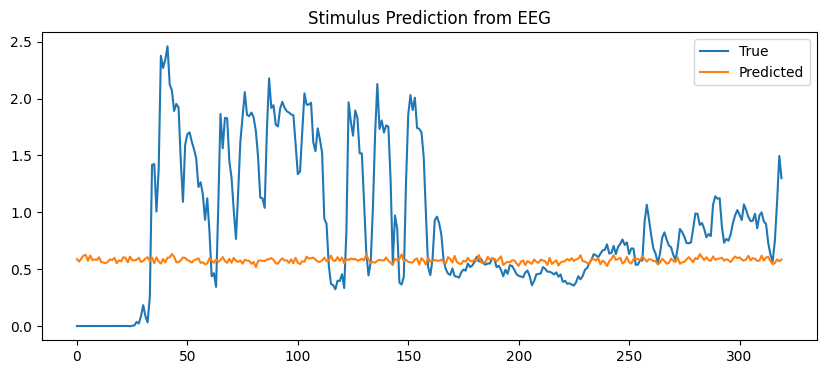

In [62]:
import matplotlib.pyplot as plt

x_sample, y_true = X_test[0:1], y_test[0:1]

model.eval()
with torch.no_grad():
    x_sample = x_sample.to(device)           # Move to GPU if available
    y_pred = model(x_sample).squeeze().cpu()  # Move prediction back to CPU for plotting

plt.figure(figsize=(10, 4))
plt.plot(y_true.squeeze().numpy(), label='True')
plt.plot(y_pred.numpy(), label='Predicted')
plt.legend()
plt.title("Stimulus Prediction from EEG")
plt.show()
